In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing import image 

In [2]:
# ====== 1. Phân chia dữ liệu ======
# Đường dẫn tới dataset gốc
dataset_dir = "D:/DATN/DATN_SyDanhVinh/skin_dataset"
output_dir = "D:/DATN/DATN_SyDanhVinh/model_dataset"

# Tạo thư mục phân chia
for split in ['train', 'validation', 'test']:
    for class_name in ['benign', 'malignant']:
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# Phân chia dữ liệu cho từng lớp
for class_name in ['benign', 'malignant']:
    source_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(source_dir)
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)
    for img in train_images:
        shutil.move(os.path.join(source_dir, img), os.path.join(output_dir, 'train', class_name, img))
    for img in val_images:
        shutil.move(os.path.join(source_dir, img), os.path.join(output_dir, 'validation', class_name, img))
    for img in test_images:
        shutil.move(os.path.join(source_dir, img), os.path.join(output_dir, 'test', class_name, img))

print("Dữ liệu đã được phân chia hoàn tất!")

Dữ liệu đã được phân chia hoàn tất!


In [10]:
output_dir = "D:/DATN/DATN_SyDanhVinh/model_dataset"

In [11]:
# Đường dẫn đến các thư mục train, validation, test
train_dir = "D:/DATN/DATN_SyDanhVinh/model_dataset/train"
validation_dir = "D:/DATN/DATN_SyDanhVinh/model_dataset/validation"
test_dir = "D:/DATN/DATN_SyDanhVinh/model_dataset/test"

# Hàm đếm số lượng ảnh trong thư mục
def count_images_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

# Kiểm tra số lượng ảnh cho mỗi thư mục trong dataset đã chia
train_benign_count = count_images_in_dir(os.path.join(train_dir, 'Benign'))
train_malignant_count = count_images_in_dir(os.path.join(train_dir, 'Malignant'))

validation_benign_count = count_images_in_dir(os.path.join(validation_dir, 'Benign'))
validation_malignant_count = count_images_in_dir(os.path.join(validation_dir, 'Malignant'))

test_benign_count = count_images_in_dir(os.path.join(test_dir, 'Benign'))
test_malignant_count = count_images_in_dir(os.path.join(test_dir, 'Malignant'))

# In kết quả
print(f"Số lượng ảnh trong tập huấn luyện (train):")
print(f"  - Benign: {train_benign_count}")
print(f"  - Malignant: {train_malignant_count}")
print(f"Số lượng ảnh trong tập validation:")
print(f"  - Benign: {validation_benign_count}")
print(f"  - Malignant: {validation_malignant_count}")
print(f"Số lượng ảnh trong tập kiểm tra (test đã chia):")
print(f"  - Benign: {test_benign_count}")
print(f"  - Malignant: {test_malignant_count}")

Số lượng ảnh trong tập huấn luyện (train):
  - Benign: 5102
  - Malignant: 4613
Số lượng ảnh trong tập validation:
  - Benign: 1093
  - Malignant: 988
Số lượng ảnh trong tập kiểm tra (test đã chia):
  - Benign: 1094
  - Malignant: 989


In [12]:
# ====== 2. Chuẩn bị dữ liệu ======
train_dir = os.path.join(output_dir, 'train')
validation_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(112, 112),
                                               batch_size=32,
                                               class_mode='binary')

validation_data = test_datagen.flow_from_directory(validation_dir,
                                                   target_size=(112, 112),
                                                   batch_size=32,
                                                   class_mode='binary')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(112, 112),
                                             batch_size=32,
                                             class_mode='binary')

Found 9715 images belonging to 2 classes.
Found 2081 images belonging to 2 classes.
Found 2083 images belonging to 2 classes.


In [13]:
# ====== 3. Xây dựng mô hình CNN ======
model = Sequential([
    # Lớp tích chập
    Conv2D(16, (3, 3), activation='relu', input_shape=(112, 112, 3)),  # Giảm số lượng bộ lọc
    # Lớp gộp
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # Chuyển dữ liệu từ ma trận 2D thành vector 1D để đưa vào lớp Dense
    Flatten(),
    Dense(128, activation='relu'),  # Giảm số lượng nơ-ron
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 110, 110, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 55, 55, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 53, 53, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,774,241 (10.58 MB)

 Trainable params: 2,774,241 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# ====== 4. Huấn luyện mô hình ======
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Kiểm tra nếu mô hình đã tồn tại
model_path = 'my_model.h5'
if os.path.exists(model_path):
    model = load_model(model_path)  # Tải mô hình đã lưu
    print("Mô hình đã được tải thành công từ:", model_path)
    history = None  # Đặt history là None khi mô hình được tải
else:
    history = model.fit(train_data,
                        epochs=20,
                        validation_data=validation_data,
                        callbacks=[early_stopping, reduce_lr])
    model.save(model_path)  # Lưu mô hình sau khi huấn luyện

Epoch 1/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 227s 735ms/step - accuracy: 0.6873 - loss: 0.5856 - val_accuracy: 0.8429 - val_loss: 0.3701 - learning_rate: 0.0010
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 96s 317ms/step - accuracy: 0.8090 - loss: 0.4196 - val_accuracy: 0.8554 - val_loss: 0.3486 - learning_rate: 0.0010
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 92s 304ms/step - accuracy: 0.8314 - loss: 0.3949 - val_accuracy: 0.8323 - val_loss: 0.3735 - learning_rate: 0.0010
Epoch 4/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 94s 309ms/step - accuracy: 0.8315 - loss: 0.3774 - val_accuracy: 0.8260 - val_loss: 0.4337 - learning_rate: 0.0010
Epoch 5/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 92s 302ms/step - accuracy: 0.8374 - loss: 0.3711 - val_accuracy: 0.8534 - val_loss: 0.3283 - learning_rate: 2.0000e-04
Epoch 6/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 136s 281ms/step - accuracy: 0.8512 - loss: 0.3410 - val_accuracy: 0.8616 - val_loss: 0.3231 - learning_rate: 2.0000e-04
Epoch 7/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 92s 304ms/step - acc

66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 334ms/step - accuracy: 0.8818 - loss: 0.2880
Test Accuracy: 0.87


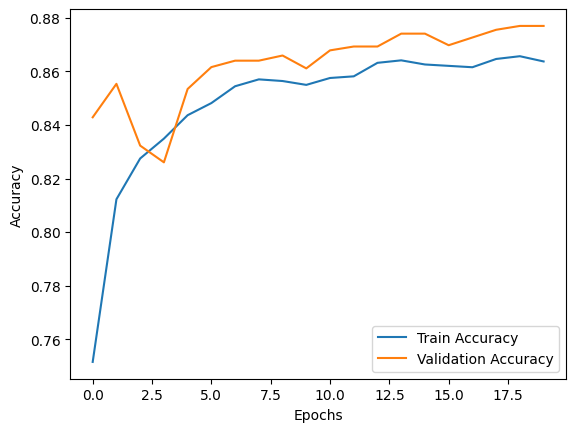

In [15]:
# ====== 5. Đánh giá và trực quan hóa ======
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

# Chỉ vẽ đồ thị nếu history không phải là None
if history is not None:
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [17]:
# ====== 6. Dự đoán ======
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(112, 112))  # Đảm bảo kích thước ảnh đúng
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Kết quả: Ác tính"
    else:
        return "Kết quả: Lành tính"

# Ví dụ sử dụng hàm dự đoán
img_path = 'D:/DATN/DATN_SyDanhVinh/model_dataset/validation/Benign/107.jpg'  # Thay bằng ảnh thực tế
result = predict_image(img_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Kết quả: Lành tính
